In [13]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import math

In [2]:
dataset_path = '/home/bot/myprojectdir/dataset/'

In [3]:
df = pd.read_csv(dataset_path+'processed/cleanDatasetWithEncoding.csv')

In [4]:
old_memory_usage = df.memory_usage().sum()
#change the variable types for low memory usage
#int64 to int32,,, float64 to float32
integer = []
f = []
for i in df.columns[:-1]:
    if df[i].dtype == "int64": integer.append(i)
    else : f.append(i)

df[integer] = df[integer].astype("int32")
df[f] = df[f].astype("float32")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520911 entries, 0 to 2520910
Data columns (total 71 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   DestinationPort          float32
 1   FlowDuration             float32
 2   TotalFwdPackets          float32
 3   TotalBackwardPackets     float32
 4   TotalLengthofFwdPackets  float32
 5   TotalLengthofBwdPackets  float32
 6   FwdPacketLengthMax       float32
 7   FwdPacketLengthMin       float32
 8   FwdPacketLengthMean      float32
 9   FwdPacketLengthStd       float32
 10  BwdPacketLengthMax       float32
 11  BwdPacketLengthMin       float32
 12  BwdPacketLengthMean      float32
 13  BwdPacketLengthStd       float32
 14  FlowBytess               float32
 15  FlowPacketss             float32
 16  FlowIATMean              float32
 17  FlowIATStd               float32
 18  FlowIATMax               float32
 19  FlowIATMin               float32
 20  FwdIATTotal              float32
 21  FwdIATMe

In [5]:
new_memory_usage = df.memory_usage().sum()
old_vs_new = (old_memory_usage - new_memory_usage) / old_memory_usage * 100
print(f"%{old_vs_new} lower memory usage")

%49.295770241184364 lower memory usage


In [6]:
# drop one variable features 
one_variable_list = []
for i in df.columns:
    if df[i].value_counts().nunique() < 2:
        one_variable_list.append(i)
df.drop(one_variable_list,axis=1,inplace=True)
df.columns =  df.columns.str.strip()

In [7]:
# drop nan and infinite rows
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

In [8]:
# drop duplicate rows
df =  df.drop_duplicates(keep="first")
df.reset_index(drop=True,inplace=True)

In [9]:
#feature reduction 
#dropping very high correlated features 
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
df =  df.drop(to_drop, axis=1)
df.shape

/home/bot/myprojectdir/myprojectenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


(2497928, 48)

In [10]:
x = df.drop(["Label"],axis=1)
y = df["Label"]

In [11]:
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

# Data splitting
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.35,random_state=42,stratify=y)

In [14]:
class_dist = dict(Y_train.value_counts())
min = class_dist[7]
max_ten_perct = math.floor(class_dist[14]*0.1)
min_diff = max_ten_perct - min
for key in class_dist:
  if class_dist[key] < max_ten_perct:
    class_dist[key] = class_dist[key] + min_diff
print(class_dist)

{14: 1346931, 3: 247036, 1: 217895, 9: 193637, 2: 141369, 6: 138541, 5: 138179, 4: 138084, 10: 136778, 0: 135952, 11: 135642, 13: 135110, 8: 134710, 12: 134700, 7: 134693}


In [16]:
from imblearn.over_sampling import SMOTE

# Using strategy
'''
We are making sure that the minority class is atleast 10% of the majority class.
So,
1. We calculate the 10% of the majority class.
2. Then, find how less is the minority class from the 10% of the majority class
3. Then, added the value from above step to all the classes which are less than 10 of the majority class

Here, as our dataset is quite large we tried to reduce the majority class by 50% and then do the above steps.
'''

smote = SMOTE(random_state=42, sampling_strategy=class_dist,n_jobs=-1)
X_train, Y_train = smote.fit_resample(X_train, Y_train)

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
#Fitting Models
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier

startNB = time.time()


# Naive Baye model training
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, Y_train)
print("Naive Bayes training time", time.time()-startNB)

startDT = time.time()
# Training Decision Tree models
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', random_state=0)
#The division quality measurement function supports the "die" criteria for dirt and the "entropy" criteria for obtaining information,
DTC_Classifier.fit(X_train, Y_train)
print("Training time model decision tree", time.time()-startDT)

startKNN = time.time()
# Training KNeighborsClassifier model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1, n_neighbors=3, metric='minkowski', algorithm='auto') 
#n_jobs = -1 means it uses all processors, algorithm = 'auto' itself applies the appropriate algorithm based on passed values, n_neighbors = 3 takes into account 3 nearest neighbors, eucledian distance
KNN_Classifier.fit(X_train, Y_train); 
print("KNN model training time", time.time()-startKNN)

Naive Bayes training time 3.843339204788208
Training time model decision tree 108.62261533737183
KNN model training time 0.35650110244750977


In [19]:
logmodel = LogisticRegression(max_iter=1000,multi_class='ovr', n_jobs=-1, random_state=1, solver='saga')
st_time = time.time()
logmodel.fit(X_train, Y_train)
end_time = time.time()
print('Training time for Logistic Regression= %s'%(end_time-st_time))

Training time for Logistic Regression= 144.61966276168823


In [20]:
from sklearn.metrics import classification_report,confusion_matrix,precision_recall_fscore_support,balanced_accuracy_score, f1_score, precision_score, recall_score
def evaluate(y_test, predictions):
    report = classification_report(y_test,predictions)
    micro_avg = list(precision_recall_fscore_support(y_test,predictions,average='micro'))
    print("### OVERALL REPORT ###")
    print(report)
    print('### MICRO AVERAGE ###')
    plt.figure(figsize=(15,10)) # (width, height)
    print('### Weighted F1 ###')
    print("Weighted f1 = "+str(format(f1_score(y_test,predictions, average='weighted'),'.4f'))+"\n")
    print('### Weighted Precision and Recall')
    print("Weighted precision = "+str(format(precision_score(y_test,predictions, average='weighted'),'.4f'))+"\nWeighted recall = "+str(format(recall_score(y_test,predictions, average='weighted'),'.4f'))+"\n")
    sns.heatmap(confusion_matrix(y_test,predictions),xticklabels= ['Bot','DDoS','DoSGoldenEye','DoSHulk','DoSSlowhttptest','DoSslowloris','FTPPatator','Heartbleed','Infiltration','PortScan','SSHPatator','WebAttackBruteForce','WebAttackSqlInjection','WebAttackXSS','normal'], yticklabels=['Bot','DDoS','DoSGoldenEye','DoSHulk','DoSSlowhttptest','DoSslowloris','FTPPatator','Heartbleed','Infiltration','PortScan','SSHPatator','WebAttackBruteForce','WebAttackSqlInjection','WebAttackXSS','normal'],annot=True,fmt='g')

In [21]:
st_time = time.time()
knn_predictions = KNN_Classifier.predict(X_test)
end_time = time.time()
print('Prediction time for KNN testing data = %s'%(end_time-st_time))

Prediction time for KNN testing data = 85584.42137908936


In [22]:
st_time =time.time()
dt_predictions = DTC_Classifier.predict(X_test)
end_time = time.time()
print('Prediction time for Decision Tree testing data = %s'%(end_time-st_time))

Prediction time for Decision Tree testing data = 0.1525437831878662


In [23]:
st_time = time.time()
bnb_predictions = BNB_Classifier.predict(X_test)
end_time = time.time()
print('Prediction time for Naive Bayes testing data = %s'%(end_time-st_time))

Prediction time for Naive Bayes testing data = 0.7619912624359131


In [24]:
st_time = time.time()
lr_predictions = logmodel.predict(X_test)
end_time = time.time()
print('Prediction time for Logistic Regression testing data = %s'%(end_time-st_time))

Prediction time for Logistic Regression testing data = 0.15908479690551758


### OVERALL REPORT ###
              precision    recall  f1-score   support

           0       0.42      0.86      0.56       682
           1       1.00      1.00      1.00     44805
           2       0.97      0.99      0.98      3599
           3       1.00      1.00      1.00     60496
           4       0.97      0.99      0.98      1830
           5       0.98      0.98      0.98      1881
           6       0.99      1.00      0.99      2076
           7       1.00      1.00      1.00         4
           8       0.17      0.50      0.25        12
           9       0.92      0.98      0.95     31743
          10       0.92      0.99      0.95      1127
          11       0.70      0.59      0.64       514
          12       0.18      0.43      0.25         7
          13       0.34      0.53      0.42       228
          14       1.00      0.99      1.00    725271

    accuracy                           0.99    874275
   macro avg       0.77      0.85      0.80    874275
wei

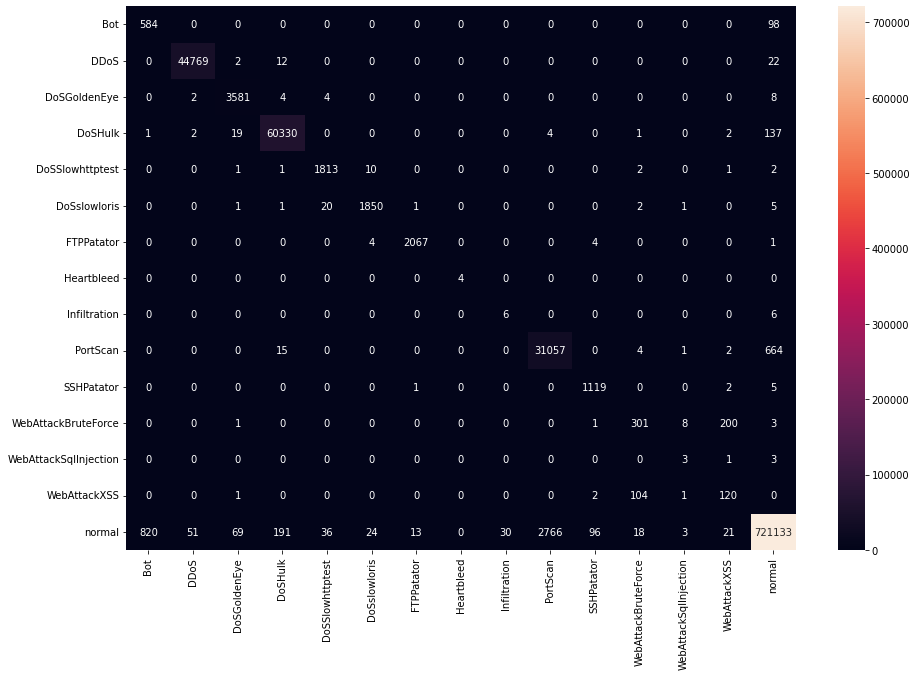

In [25]:
evaluate(Y_test,knn_predictions)

### OVERALL REPORT ###
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       682
           1       1.00      1.00      1.00     44805
           2       0.99      1.00      0.99      3599
           3       1.00      1.00      1.00     60496
           4       0.97      0.99      0.98      1830
           5       0.99      0.98      0.98      1881
           6       1.00      1.00      1.00      2076
           7       1.00      1.00      1.00         4
           8       0.85      0.92      0.88        12
           9       0.99      0.99      0.99     31743
          10       1.00      1.00      1.00      1127
          11       0.71      0.68      0.69       514
          12       0.44      0.57      0.50         7
          13       0.38      0.45      0.41       228
          14       1.00      1.00      1.00    725271

    accuracy                           1.00    874275
   macro avg       0.87      0.89      0.88    874275
wei

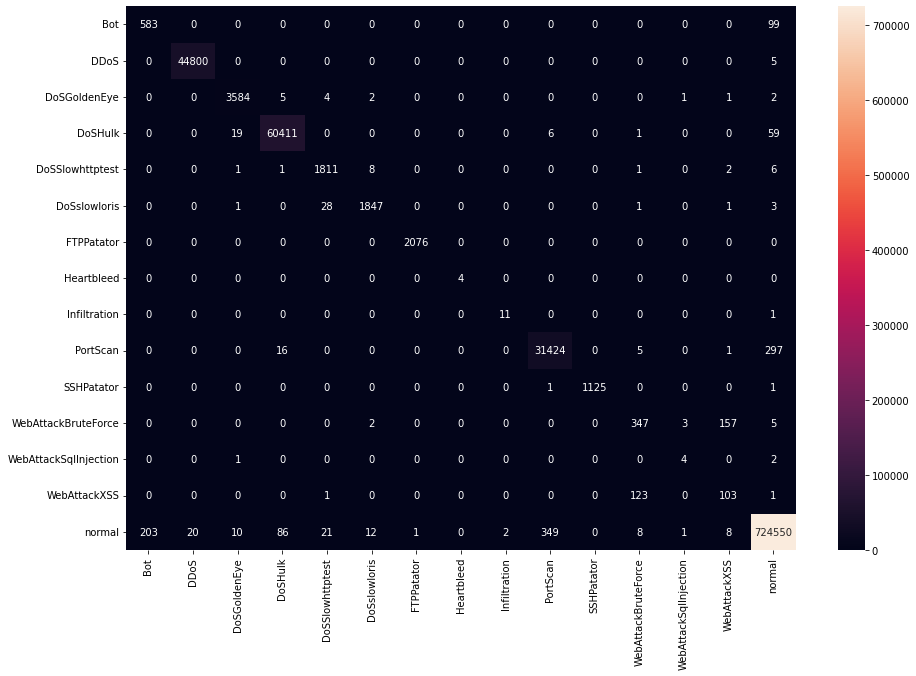

In [26]:
evaluate(Y_test,dt_predictions)

### OVERALL REPORT ###
              precision    recall  f1-score   support

           0       0.01      0.90      0.01       682
           1       0.73      0.63      0.68     44805
           2       0.07      0.69      0.13      3599
           3       0.77      0.82      0.79     60496
           4       0.05      0.71      0.09      1830
           5       0.05      0.60      0.09      1881
           6       0.04      0.98      0.08      2076
           7       0.04      1.00      0.08         4
           8       0.00      1.00      0.00        12
           9       0.74      0.98      0.84     31743
          10       0.04      0.91      0.08      1127
          11       0.00      0.04      0.00       514
          12       0.00      0.29      0.00         7
          13       0.01      0.93      0.02       228
          14       0.99      0.55      0.70    725271

    accuracy                           0.59    874275
   macro avg       0.24      0.73      0.24    874275
wei

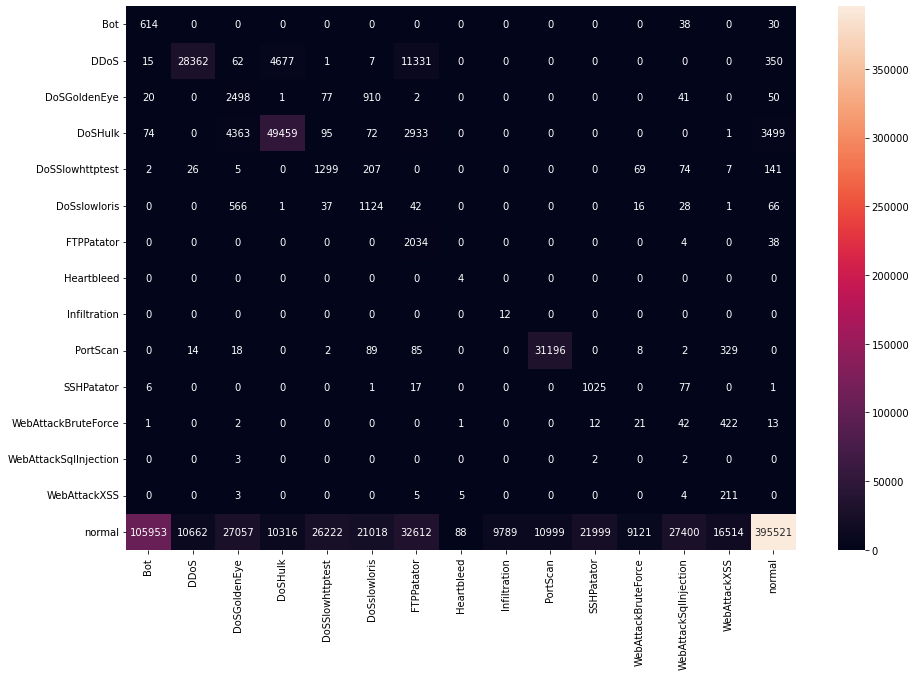

In [27]:
evaluate(Y_test,bnb_predictions)

### OVERALL REPORT ###
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       682
           1       0.76      0.56      0.65     44805
           2       0.31      0.83      0.45      3599
           3       0.84      0.85      0.85     60496
           4       0.23      0.73      0.35      1830
           5       0.18      0.52      0.27      1881
           6       0.20      0.33      0.25      2076
           7       0.01      1.00      0.01         4
           8       0.00      0.92      0.01        12
           9       0.56      0.09      0.16     31743
          10       0.00      0.00      0.00      1127
          11       0.00      0.00      0.00       514
          12       0.00      0.29      0.00         7
          13       0.01      0.93      0.02       228
          14       0.93      0.89      0.91    725271

    accuracy                           0.84    874275
   macro avg       0.27      0.53      0.26    874275
wei

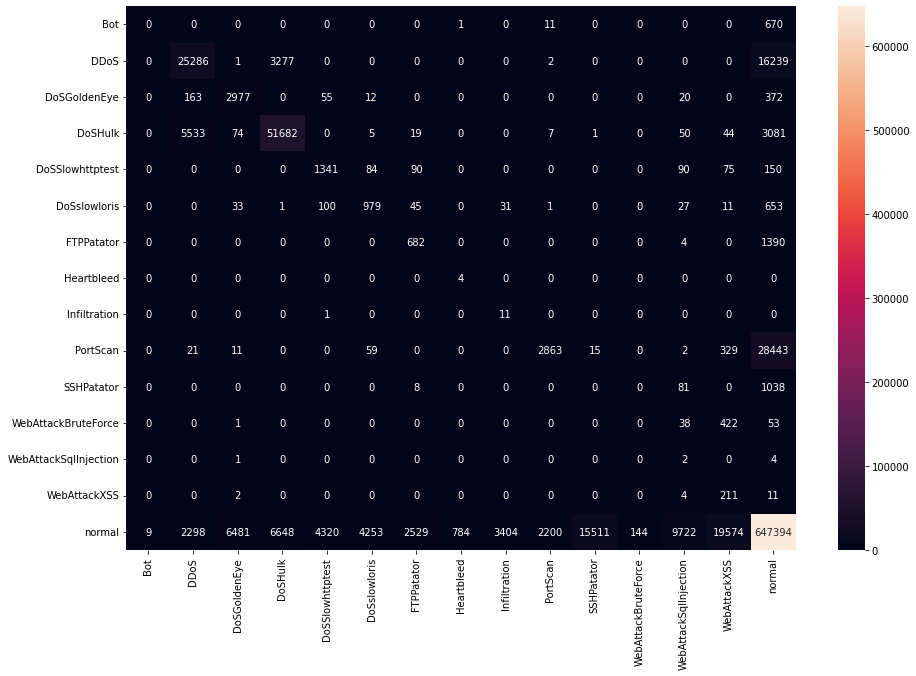

In [28]:
evaluate(Y_test,lr_predictions)

In [29]:
startDT = time.time()
# Training Decision Tree models
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', random_state=0,max_depth=15)
#The division quality measurement function supports the "die" criteria for dirt and the "entropy" criteria for obtaining information,
DTC_Classifier.fit(X_train, Y_train)
print("Training time model decision tree", time.time()-startDT)

Training time model decision tree 94.89480829238892


In [30]:
st_time =time.time()
dt_predictions = DTC_Classifier.predict(X_test)
end_time = time.time()
print('Prediction time for Decision Tree testing data = %s'%(end_time-st_time))

Prediction time for Decision Tree testing data = 0.14245033264160156


### OVERALL REPORT ###
              precision    recall  f1-score   support

           0       0.38      0.95      0.55       682
           1       1.00      1.00      1.00     44805
           2       0.99      1.00      0.99      3599
           3       1.00      1.00      1.00     60496
           4       0.98      0.99      0.99      1830
           5       0.97      1.00      0.98      1881
           6       1.00      1.00      1.00      2076
           7       1.00      1.00      1.00         4
           8       0.86      1.00      0.92        12
           9       0.99      1.00      0.99     31743
          10       1.00      1.00      1.00      1127
          11       0.76      0.56      0.65       514
          12       0.29      0.71      0.42         7
          13       0.36      0.68      0.47       228
          14       1.00      1.00      1.00    725271

    accuracy                           1.00    874275
   macro avg       0.84      0.93      0.86    874275
wei

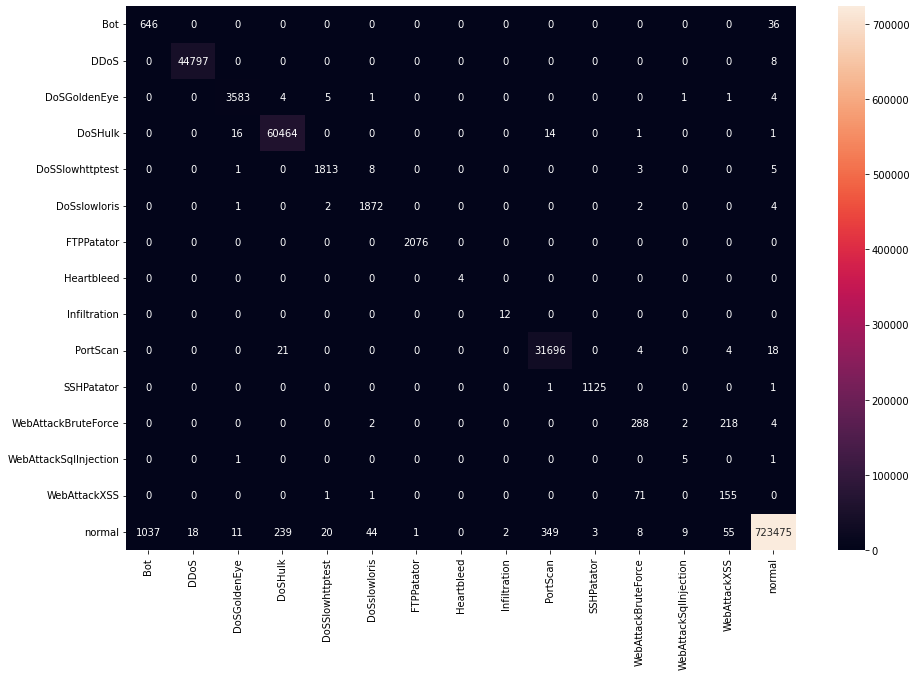

In [31]:
evaluate(Y_test,dt_predictions)